### This notebook demonstrates the ability of the DisparateImpactRemover algorithm.
The algorithm corrects for imbalanced selection rates between unprivileged and privileged groups at various levels of repair. It follows the guidelines set forth by [1] for training the algorithm and classifier and uses the AdultDataset as an example.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

In [2]:
from matplotlib import pyplot as plt

import sys
sys.path.append("../")
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as SVM
from sklearn.preprocessing import MinMaxScaler

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric

from IPython.display import Markdown, display

#### Dataset
https://archive.ics.uci.edu/ml/datasets/adult

This data was extracted from the census bureau database.

48842 instances, mix of continuous and discrete    (train=32561, test=16281)

45222 if instances with unknown values are removed (train=30162, test=15060)

In [3]:
f = open("adult.data","r")

In [4]:
fl =f.readlines()

In [5]:
final_list = []
for line in fl:
    line = line.replace(" ", "")
    line = line.rstrip()
    l = line.split(",")
#     print(l)
    if l[len(l) - 1] == '>50K':
        l[len(l) - 1] = 1
    else:
        l[len(l) - 1] = 0
# print(l)
#     print(l)
    final_list.append(l)

In [6]:
f.close()

In [7]:
adult_df = pd.DataFrame(final_list, columns=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                                  'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
                                  'native-country', 'income-per-year'])

In [8]:
adult_df.shape

(32562, 15)

In [9]:
adult_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-per-year
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0.0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0.0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0.0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0.0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0.0


In [10]:
adult_df.dtypes

age                 object
workclass           object
fnlwgt              object
education           object
education-num       object
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain        object
capital-loss        object
hours-per-week      object
native-country      object
income-per-year    float64
dtype: object

In [11]:
adult_df = adult_df.drop(['fnlwgt'], axis=1)

In [12]:
adult_df = adult_df.dropna()

In [13]:
adult_df.shape

(32561, 14)

In [14]:
for col in adult_df.columns:
    print(adult_df[col].unique())

['39' '50' '38' '53' '28' '37' '49' '52' '31' '42' '30' '23' '32' '40'
 '34' '25' '43' '54' '35' '59' '56' '19' '20' '45' '22' '48' '21' '24'
 '57' '44' '41' '29' '18' '47' '46' '36' '79' '27' '67' '33' '76' '17'
 '55' '61' '70' '64' '71' '68' '66' '51' '58' '26' '60' '90' '75' '65'
 '77' '62' '63' '80' '72' '74' '69' '73' '81' '78' '88' '82' '83' '84'
 '85' '86' '87']
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
['13' '9' '7' '14' '5' '10' '12' '11' '4' '16' '15' '3' '6' '2' '1' '8']
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 

In [15]:
adult_df = adult_df.replace({'?':np.nan}).dropna()

In [16]:
adult_df.shape

(30162, 14)

In [17]:
int_cols = ['age',  'education-num','capital-gain', 'capital-loss', 'hours-per-week', 'income-per-year']
for c in int_cols:
    adult_df[c] = adult_df[c].astype(int)

In [18]:
adult_df.dtypes

age                 int64
workclass          object
education          object
education-num       int64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income-per-year     int64
dtype: object

In [19]:
adult_df['age'].describe()

count    30162.000000
mean        38.437902
std         13.134665
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64

In [20]:
adult_df['capital-gain'].describe()

count    30162.000000
mean      1092.007858
std       7406.346497
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64

In [21]:
adult_df['capital-loss'].describe()

count    30162.000000
mean        88.372489
std        404.298370
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital-loss, dtype: float64

#### To add your own dataset to aif360:
Identify the following in the dataset:

Favorable label

Unfavorable label

Privileged group

Unprivileged group

#### For this dataset:
Sex is the protected attribute. 
#label 0: Income is less than 50K

#label 1: Income is more than 50K

Sex 0: Female and Gender 1: Male

privileged_groups = [{'sex': 0}]

unprivileged_groups = [{'sex': 1}]

favorable_label = 1 

unfavorable_label = 0

### Importing the same dataset from the aif360 toolkit

In [22]:
protected = 'sex'

# AdultDataset(label_name='income-per-year', favorable_classes=['>50K', '>50K.'], protected_attribute_names=['race', 'sex'], privileged_classes=[['White'], ['Male']], instance_weights_name=None, categorical_features=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country'], features_to_keep=[], features_to_drop=['fnlwgt'], na_values=['?'], custom_preprocessing=None, metadata={'label_maps': [{0.0: '<=50K', 1.0: '>50K'}], 'protected_attribute_maps': [{0.0: 'Non-white', 1.0: 'White'}, {0.0: 'Female', 1.0: 'Male'}]})
ad = AdultDataset(protected_attribute_names=[protected],
    privileged_classes=[['Male']], categorical_features=[],
    features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'])

In [23]:
# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(ad.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(ad.favorable_label, ",",ad.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(ad.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(ad.privileged_protected_attributes, ",", ad.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(ad.feature_names)

#### Dataset shape

(48842, 6)


#### Favorable and unfavorable labels

1.0 , 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] , [array([0.])]


#### Dataset feature names

['age', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']


In [24]:
scaler = MinMaxScaler(copy=False)

<b>split(num_or_size_splits, shuffle=False)</b>

If num_or_size_splits is an int, k, the value is the number of equal-sized folds to make (if k does not evenly divide the dataset these folds are approximately equal-sized). 

If num_or_size_splits is an array of type int, the values are taken as the indices at which to split the dataset. 

If the values are floats (< 1.), they are considered to be fractional proportions of the dataset at which to split.

In [25]:
train, test = ad.split([32561])

In [26]:
train.features.shape

(32561, 6)

In [27]:
test.features.shape

(16281, 6)

#### We then fit the data to the scalar object

In [28]:
train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)


#### We will take the index of the protect attribute column and delete it while fitting the end classifier on the data

In [29]:
index = train.feature_names.index(protected)
print(index)

2


In [30]:
train.feature_names

['age',
 'education-num',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

##### Logistic Regression
Like many other learning algorithms in scikit-learn, LogisticRegression comes with a built-in method of handling imbalanced classes. If we have highly imbalanced classes and have no addressed it during preprocessing, we have the option of using the class_weight parameter to weight the classes to make certain we have a balanced mix of each class. Specifically, the balanced argument will automatically weigh classes inversely proportional to their frequency:

wj = n/(k*nj)

where 
wj is the weight to class j,

n is the number of observations, 

nj is the number of observations in class j, and 

k is the total number of classes.

In [32]:
DIs = []
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(train)
    test_repd = di.fit_transform(test)
    
    # Delete the sex feature from the data while fitting the end clasifier
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    
    # flatten array
    y_tr = train_repd.labels.ravel()
    
    lmod = LogisticRegression(class_weight='balanced')
    lmod.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)

    p = [{protected: 1}]
    u = [{protected: 0}]
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups=u)
    DIs.append(cm.disparate_impact())

100%|██████████| 11/11 [00:29<00:00,  2.12s/it]


<IPython.core.display.Javascript object>


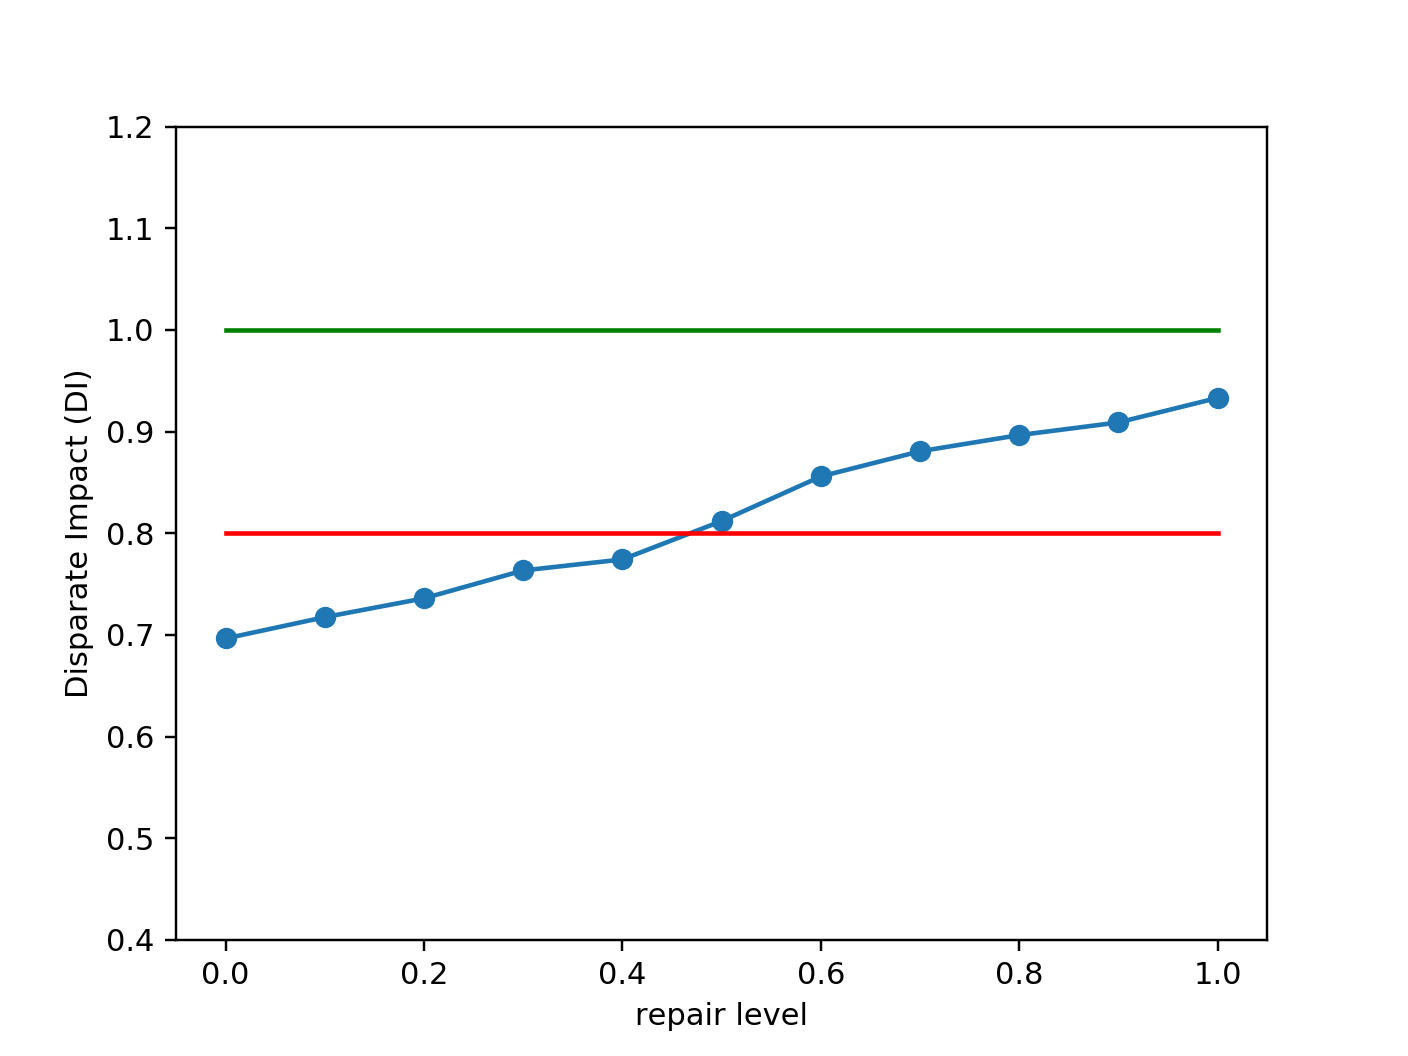

In [33]:
%matplotlib notebook

plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()

    References:
        .. [1] M. Feldman, S. A. Friedler, J. Moeller, C. Scheidegger, and
           S. Venkatasubramanian, "Certifying and removing disparate impact."
           ACM SIGKDD International Conference on Knowledge Discovery and Data
           Mining, 2015.